# **LG01 - Prediksi Klasifikasi Label Perbaikan - RISTEK FASILKOM UI DATATHON 2025**

---


Setelah Model 1 mengidentifikasi cacat dan Model 2 mengonfirmasi penilaian "Bad" dari operator, Task 3 bertujuan untuk menjawab pertanyaan paling spesifik: "Bagaimana seharusnya komponen yang sudah pasti cacat ini ditangani?"

Tugas ini adalah masalah klasifikasi multikelas di mana kita akan memprediksi RepairLabel (NotPossibleToRepair, FalseScrap, NotYetClassified). Model yang sukses pada tahap ini akan menjadi alat bantu keputusan yang sangat kuat bagi tim perbaikan, memungkinkan mereka untuk memprioritaskan sumber daya dan mengidentifikasi produk yang tidak dapat diselamatkan sejak dini.

## **Import Library & Dataset**

---



In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 24.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, log_loss, f1_score
from sklearn.utils.class_weight import compute_class_weight

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
import optuna
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

import warnings
warnings.filterwarnings('ignore')


**Upload kaggle.json**

Open Kaggle -> Settings -> Account -> API -> Create New Token -> Upload the file here

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!/bin/bash
!kaggle datasets download rizkyfadhilahjhhhh/dataset-lg01

Dataset URL: https://www.kaggle.com/datasets/rizkyfadhilahjhhhh/dataset-lg01
License(s): unknown
 95% 307M/323M [00:00<00:00, 431MB/s]
100% 323M/323M [00:00<00:00, 467MB/s]


In [ ]:
!unzip dataset-lg01.zip

Archive:  dataset-lg01.zip
  inflating: PCB Dataset/AOI_testing.csv  
  inflating: PCB Dataset/AOI_training.csv  
  inflating: PCB Dataset/SPI_testing_0.csv  
  inflating: PCB Dataset/SPI_testing_1.csv  
  inflating: PCB Dataset/SPI_training_0.csv  
  inflating: PCB Dataset/SPI_training_1.csv  
  inflating: PCB Dataset/SPI_training_2.csv  
  inflating: PCB Dataset/SPI_training_3.csv  


In [ ]:
aoi_train = pd.read_csv('/content/PCB Dataset/AOI_training.csv')
spi_0 = pd.read_csv('/content/PCB Dataset/SPI_training_0.csv')
spi_1 = pd.read_csv('/content/PCB Dataset/SPI_training_1.csv')
spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')
spi_3 = pd.read_csv('/content/PCB Dataset/SPI_training_3.csv')

merged_spi = pd.concat([spi_0, spi_1, spi_2, spi_3])

## **Data Preprocessing & Feature Engineering**

---



Penggabungan Data: Melakukan left join dari data AOI ke data SPI.

Target Engineering: Membuat ketiga variabel target hirarkis, termasuk target_3_repair_label yang menggunakan LabelEncoder untuk mengubah label string menjadi format numerik yang bisa dipahami model.

Feature Engineering: Membuat fitur-fitur yang sama seperti task-task sebelumnya untuk menjaga konsistensi.

In [ ]:
def preprocess_task3_only(spi_df, aoi_df):

    for df in [spi_df, aoi_df]:
        for col in ['FigureID', 'PinNumber']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    spi_df['Datetime'] = pd.to_datetime(spi_df['Date'] + ' ' + spi_df['Time'], errors='coerce')
    merged_cols = ["PanelID", "FigureID", "ComponentID", "PinNumber"]
    df = pd.merge(aoi_df, spi_df, on=merged_cols, how='left')
    df = df[df['Datetime'].notna()].copy()


    df = df[(df['AOILabel'] != 'Soldered') & (df['OperatorLabel'] == 'Bad')].copy()
    df['RepairLabel'] = df['RepairLabel'].fillna("Unknown")

    le = LabelEncoder()
    df['target_repair_label'] = le.fit_transform(df['RepairLabel'])

    df['MachineID'] = df['MachineID'].astype('category').cat.codes
    df['ComponentID_cat'] = df['ComponentID'].astype('category').cat.codes
    df['Shape(um)'] = pd.to_numeric(df['Shape(um)'], errors='coerce')
    df['spi_hour'] = df['Datetime'].dt.hour
    df['spi_dayofweek'] = df['Datetime'].dt.dayofweek
    df['spi_is_weekend'] = (df['spi_dayofweek'] >= 5).astype(int)
    df['offset_magnitude'] = np.sqrt(df['OffsetX(%)']**2 + df['OffsetY(%)']**2)
    df['volume_area_ratio'] = df['Volume(%)'] / (df['Area(%)'] + 1e-6)

    cols_to_drop = [
        'PanelID', 'FigureID', 'PinNumber', 'ComponentID',
        'Date', 'Time', 'Datetime',
        'AOILabel', 'OperatorLabel', 'RepairLabel',
        'MachinePrediction', 'Result',
        'Is_Defect', 'Is_Defect_Label',
        'Volume(um3)', 'Area(um2)'
    ]
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

    return df, le

## **Optimasi Hyperparameter & Pelatihan**

---



Setelah mempersiapkan data, langkah selanjutnya adalah melatih model. Namun, daripada menggunakan hyperparameter default yang mungkin tidak optimal, kami menerapkan proses optimasi hyperparameter otomatis menggunakan Optuna.

In [ ]:
def train_best_model(model_type, X_train, y_train, X_val, y_val, n_classes):
    def objective(trial):
        if model_type == 'catboost':
            params = {
                'iterations': 500,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'depth': trial.suggest_int('depth', 4, 10),
                'loss_function': 'MultiClass',
                'eval_metric': 'TotalF1',
                'verbose': 0,
                'random_seed': 42
            }
            model = cb.CatBoostClassifier(**params)
        elif model_type == 'lightgbm':
            params = {
                'objective': 'multiclass',
                'num_class': n_classes,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'random_state': 42
            }
            model = lgb.LGBMClassifier(**params)
        elif model_type == 'xgboost':
            params = {
                'objective': 'multi:softprob',
                'num_class': n_classes,
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'eval_metric': 'mlogloss',
                'seed': 42
            }
            model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
        preds = model.predict(X_val)
        return f1_score(y_val, preds, average='macro')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    best_params = study.best_params

    if model_type == 'catboost':
        best_params.update({'iterations': 500, 'loss_function': 'MultiClass', 'eval_metric': 'TotalF1', 'random_seed': 42, 'verbose': 0, 'early_stopping_rounds': 30})
        model = cb.CatBoostClassifier(**best_params)
    elif model_type == 'lightgbm':
        best_params.update({'objective': 'multiclass', 'num_class': n_classes, 'random_state': 42, 'early_stopping_rounds': 30})
        model = lgb.LGBMClassifier(**best_params)
    elif model_type == 'xgboost':
        best_params.update({'objective': 'multi:softprob', 'num_class': n_classes, 'eval_metric': 'mlogloss', 'seed': 42, 'early_stopping_rounds': 30})
        model = xgb.XGBClassifier(**best_params)

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    return model

## **Pendekatan Alternatif: LSTM**

---



In [ ]:
class PCBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, output_size)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [ ]:
def train_lstm(X_train, y_train, X_val, y_val, n_classes):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    train_loader = DataLoader(PCBDataset(pd.DataFrame(X_train_scaled), y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(PCBDataset(pd.DataFrame(X_val_scaled), y_val), batch_size=64)
    model = LSTMClassifier(input_size=X_train.shape[1], output_size=n_classes)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_val_loss = float('inf')
    patience, counter = 3, 0

    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                loss = loss_fn(model(xb), yb)
                val_losses.append(loss.item())
        avg_val = np.mean(val_losses)
        print(f"Epoch {epoch+1}, Val Loss: {avg_val:.4f}")
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "best_lstm.pt")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_lstm.pt"))
    return model, scaler, X_val_scaled

## **Fungsi Evaluasi Model**

---



In [ ]:
def evaluate_model(y_true, y_pred, le, name):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Oranges')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## **Persiapan Data untuk Pemodelan**

---



In [ ]:
df, le = preprocess_task3_only(merged_spi, aoi_train)
X = pd.get_dummies(df.drop(columns=['target_repair_label']))
y = df['target_repair_label']
n_classes = len(le.classes_)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## **Pelatihan dan Optimasi Model**

---



In [ ]:
cat_model = train_best_model('catboost', X_train, y_train, X_val, y_val, n_classes)
lgb_model = train_best_model('lightgbm', X_train, y_train, X_val, y_val, n_classes)
xgb_model = train_best_model('xgboost', X_train, y_train, X_val, y_val, n_classes)
lstm_model, scaler_lstm, X_val_scaled = train_lstm(X_train, y_train, X_val, y_val, n_classes)

[I 2025-07-10 08:12:25,552] A new study created in memory with name: no-name-7fd4f890-975e-4f19-9af7-b2e176442f1f
[I 2025-07-10 08:12:31,121] Trial 0 finished with value: 0.8137254901960785 and parameters: {'learning_rate': 0.04437463282953547, 'depth': 7}. Best is trial 0 with value: 0.8137254901960785.
[I 2025-07-10 08:12:35,539] Trial 1 finished with value: 0.8020132486984797 and parameters: {'learning_rate': 0.0660589800193116, 'depth': 6}. Best is trial 0 with value: 0.8137254901960785.
[I 2025-07-10 08:12:45,124] Trial 2 finished with value: 0.8168193831204799 and parameters: {'learning_rate': 0.014781912404167966, 'depth': 8}. Best is trial 2 with value: 0.8168193831204799.
[I 2025-07-10 08:12:47,184] Trial 3 finished with value: 0.772735760971055 and parameters: {'learning_rate': 0.015645706529685457, 'depth': 4}. Best is trial 2 with value: 0.8168193831204799.
[I 2025-07-10 08:13:27,382] Trial 4 finished with value: 0.8061497326203207 and parameters: {'learning_rate': 0.063627

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-10 08:17:42,353] Trial 1 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.06904139212721226, 'max_depth': 9}. Best is trial 1 with value: 0.7994142200708548.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:42,494] Trial 2 finished with value: 0.8086773206392385 and parameters: {'learning_rate': 0.029150588597709803, 'max_depth': 9}. Best is trial 2 with value: 0.8086773206392385.
[I 2025-07-10 08:17:42,613] Trial 3 finished with value: 0.7698972254375812 and parameters: {'learning_rate': 0.025304395223689748, 'max_depth': 6}. Best is trial 2 with value: 0.8086773206392385.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-10 08:17:42,717] Trial 4 finished with value: 0.7457943629429172 and parameters: {'learning_rate': 0.017964789506087063, 'max_depth': 5}. Best is trial 2 with value: 0.8086773206392385.
[I 2025-07-10 08:17:42,869] Trial 5 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.0786699039081043, 'max_depth': 9}. Best is trial 2 with value: 0.8086773206392385.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-10 08:17:43,015] Trial 6 finished with value: 0.7720588235294118 and parameters: {'learning_rate': 0.01989099558208345, 'max_depth': 9}. Best is trial 2 with value: 0.8086773206392385.
[I 2025-07-10 08:17:43,090] Trial 7 finished with value: 0.7541749283983256 and parameters: {'learning_rate': 0.01698631417206295, 'max_depth': 4}. Best is trial 2 with value: 0.8086773206392385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:43,244] Trial 8 finished with value: 0.7906585636203799 and parameters: {'learning_rate': 0.03604605096038855, 'max_depth': 9}. Best is trial 2 with value: 0.8086773206392385.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:43,383] Trial 9 finished with value: 0.8112889060257481 and parameters: {'learning_rate': 0.07610694761930975, 'max_depth': 7}. Best is trial 9 with value: 0.8112889060257481.
[I 2025-07-10 08:17:43,527] Trial 10 finished with value: 0.7817492449071396 and parameters: {'learning_rate': 0.09867468411936528, 'max_depth': 7}. Best is trial 9 with value: 0.8112889060257481.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:43,675] Trial 11 finished with value: 0.7823529411764705 and parameters: {'learning_rate': 0.050875099115902364, 'max_depth': 7}. Best is trial 9 with value: 0.8112889060257481.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-10 08:17:43,842] Trial 12 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.0479577433646956, 'max_depth': 10}. Best is trial 9 with value: 0.8112889060257481.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:44,014] Trial 13 finished with value: 0.7906585636203799 and parameters: {'learning_rate': 0.07146183366864453, 'max_depth': 8}. Best is trial 9 with value: 0.8112889060257481.
[I 2025-07-10 08:17:44,144] Trial 14 finished with value: 0.7942237249929557 and parameters: {'learning_rate': 0.08747609308017588, 'max_depth': 7}. Best is trial 9 with value: 0.8112889060257481.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:44,335] Trial 15 finished with value: 0.7906585636203799 and parameters: {'learning_rate': 0.058015595089324856, 'max_depth': 10}. Best is trial 9 with value: 0.8112889060257481.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-10 08:17:44,505] Trial 16 finished with value: 0.7994142200708548 and parameters: {'learning_rate': 0.04287119113492895, 'max_depth': 8}. Best is trial 9 with value: 0.8112889060257481.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:44,668] Trial 17 finished with value: 0.7823529411764705 and parameters: {'learning_rate': 0.060095181389022215, 'max_depth': 8}. Best is trial 9 with value: 0.8112889060257481.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-07-10 08:17:44,794] Trial 18 finished with value: 0.732244008714597 and parameters: {'learning_rate': 0.010294615363504622, 'max_depth': 6}. Best is trial 9 with value: 0.8112889060257481.
[I 2025-07-10 08:17:44,909] Trial 19 finished with value: 0.7900110741971207 and parameters: {'learning_rate': 0.08328234151288576, 'max_depth': 5}. Best is trial 9 with value: 0.8112889060257481.
[I 2025-07-10 08:17:44,998] A new study created in memory with name: no-name-c1b8c4b0-c7ba-42b5-a97b-15b393bc3c48


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 19
[LightGBM] [Info] Start training from score -2.349208
[LightGBM] [Info] Start training from score -0.272612
[LightGBM] [Info] Start training from score -1.943743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

[I 2025-07-10 08:17:46,573] Trial 0 finished with value: 0.7040692640692642 and parameters: {'learning_rate': 0.01490925778558077, 'max_depth': 9}. Best is trial 0 with value: 0.7040692640692642.


[0]	validation_0-mlogloss:1.03612
[1]	validation_0-mlogloss:0.98047
[2]	validation_0-mlogloss:0.93056
[3]	validation_0-mlogloss:0.88532
[4]	validation_0-mlogloss:0.84415
[5]	validation_0-mlogloss:0.80683
[6]	validation_0-mlogloss:0.77250
[7]	validation_0-mlogloss:0.74136
[8]	validation_0-mlogloss:0.71371
[9]	validation_0-mlogloss:0.68699
[10]	validation_0-mlogloss:0.66358
[11]	validation_0-mlogloss:0.64074
[12]	validation_0-mlogloss:0.62001
[13]	validation_0-mlogloss:0.60151
[14]	validation_0-mlogloss:0.58360
[15]	validation_0-mlogloss:0.56695
[16]	validation_0-mlogloss:0.55106
[17]	validation_0-mlogloss:0.53614
[18]	validation_0-mlogloss:0.52136
[19]	validation_0-mlogloss:0.50795
[20]	validation_0-mlogloss:0.49617
[21]	validation_0-mlogloss:0.48363
[22]	validation_0-mlogloss:0.47205
[23]	validation_0-mlogloss:0.46163
[24]	validation_0-mlogloss:0.45173
[25]	validation_0-mlogloss:0.44333
[26]	validation_0-mlogloss:0.43408
[27]	validation_0-mlogloss:0.42534
[28]	validation_0-mlogloss:0.4

[I 2025-07-10 08:17:47,578] Trial 1 finished with value: 0.7781570894253654 and parameters: {'learning_rate': 0.05974174232888927, 'max_depth': 5}. Best is trial 1 with value: 0.7781570894253654.


[0]	validation_0-mlogloss:1.02842
[1]	validation_0-mlogloss:0.96749
[2]	validation_0-mlogloss:0.91334
[3]	validation_0-mlogloss:0.86360
[4]	validation_0-mlogloss:0.82024
[5]	validation_0-mlogloss:0.78042
[6]	validation_0-mlogloss:0.74462
[7]	validation_0-mlogloss:0.71187
[8]	validation_0-mlogloss:0.68313
[9]	validation_0-mlogloss:0.65683
[10]	validation_0-mlogloss:0.63264
[11]	validation_0-mlogloss:0.61000
[12]	validation_0-mlogloss:0.58977
[13]	validation_0-mlogloss:0.57074
[14]	validation_0-mlogloss:0.55330
[15]	validation_0-mlogloss:0.53754
[16]	validation_0-mlogloss:0.52343
[17]	validation_0-mlogloss:0.51066
[18]	validation_0-mlogloss:0.49857
[19]	validation_0-mlogloss:0.48708
[20]	validation_0-mlogloss:0.47646
[21]	validation_0-mlogloss:0.46612
[22]	validation_0-mlogloss:0.45711
[23]	validation_0-mlogloss:0.44786
[24]	validation_0-mlogloss:0.43904
[25]	validation_0-mlogloss:0.43031
[26]	validation_0-mlogloss:0.42285
[27]	validation_0-mlogloss:0.41524
[28]	validation_0-mlogloss:0.4

[I 2025-07-10 08:17:49,081] Trial 2 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.0674898010630218, 'max_depth': 10}. Best is trial 1 with value: 0.7781570894253654.


[0]	validation_0-mlogloss:0.99832
[1]	validation_0-mlogloss:0.91767
[2]	validation_0-mlogloss:0.84662
[3]	validation_0-mlogloss:0.78570
[4]	validation_0-mlogloss:0.73445
[5]	validation_0-mlogloss:0.68881
[6]	validation_0-mlogloss:0.65024
[7]	validation_0-mlogloss:0.61520
[8]	validation_0-mlogloss:0.58595
[9]	validation_0-mlogloss:0.55908
[10]	validation_0-mlogloss:0.53648
[11]	validation_0-mlogloss:0.51608
[12]	validation_0-mlogloss:0.49754
[13]	validation_0-mlogloss:0.48263
[14]	validation_0-mlogloss:0.46746
[15]	validation_0-mlogloss:0.45311
[16]	validation_0-mlogloss:0.44007
[17]	validation_0-mlogloss:0.42741
[18]	validation_0-mlogloss:0.41578
[19]	validation_0-mlogloss:0.40618
[20]	validation_0-mlogloss:0.39798
[21]	validation_0-mlogloss:0.39111
[22]	validation_0-mlogloss:0.38452
[23]	validation_0-mlogloss:0.37877
[24]	validation_0-mlogloss:0.37364
[25]	validation_0-mlogloss:0.36905
[26]	validation_0-mlogloss:0.36510
[27]	validation_0-mlogloss:0.36100
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:17:51,160] Trial 3 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.09766437370342763, 'max_depth': 10}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.02969
[1]	validation_0-mlogloss:0.96974
[2]	validation_0-mlogloss:0.91589
[3]	validation_0-mlogloss:0.86677
[4]	validation_0-mlogloss:0.82421
[5]	validation_0-mlogloss:0.78442
[6]	validation_0-mlogloss:0.74887
[7]	validation_0-mlogloss:0.71630
[8]	validation_0-mlogloss:0.68719
[9]	validation_0-mlogloss:0.66035
[10]	validation_0-mlogloss:0.63631
[11]	validation_0-mlogloss:0.61427
[12]	validation_0-mlogloss:0.59402
[13]	validation_0-mlogloss:0.57491
[14]	validation_0-mlogloss:0.55787
[15]	validation_0-mlogloss:0.54315
[16]	validation_0-mlogloss:0.52895
[17]	validation_0-mlogloss:0.51616
[18]	validation_0-mlogloss:0.50443
[19]	validation_0-mlogloss:0.49310
[20]	validation_0-mlogloss:0.48136
[21]	validation_0-mlogloss:0.47034
[22]	validation_0-mlogloss:0.45957
[23]	validation_0-mlogloss:0.44925
[24]	validation_0-mlogloss:0.44052
[25]	validation_0-mlogloss:0.43148
[26]	validation_0-mlogloss:0.42379
[27]	validation_0-mlogloss:0.41597
[28]	validation_0-mlogloss:0.4

[I 2025-07-10 08:17:53,273] Trial 4 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.06623256196578511, 'max_depth': 7}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.08216
[1]	validation_0-mlogloss:1.06641
[2]	validation_0-mlogloss:1.05097
[3]	validation_0-mlogloss:1.03588
[4]	validation_0-mlogloss:1.02131
[5]	validation_0-mlogloss:1.00710
[6]	validation_0-mlogloss:0.99320
[7]	validation_0-mlogloss:0.97955
[8]	validation_0-mlogloss:0.96659
[9]	validation_0-mlogloss:0.95363
[10]	validation_0-mlogloss:0.94118
[11]	validation_0-mlogloss:0.92880
[12]	validation_0-mlogloss:0.91705
[13]	validation_0-mlogloss:0.90523
[14]	validation_0-mlogloss:0.89390
[15]	validation_0-mlogloss:0.88282
[16]	validation_0-mlogloss:0.87210
[17]	validation_0-mlogloss:0.86144
[18]	validation_0-mlogloss:0.85110
[19]	validation_0-mlogloss:0.84113
[20]	validation_0-mlogloss:0.83110
[21]	validation_0-mlogloss:0.82155
[22]	validation_0-mlogloss:0.81210
[23]	validation_0-mlogloss:0.80308
[24]	validation_0-mlogloss:0.79413
[25]	validation_0-mlogloss:0.78533
[26]	validation_0-mlogloss:0.77701
[27]	validation_0-mlogloss:0.76849
[28]	validation_0-mlogloss:0.7

[I 2025-07-10 08:17:54,766] Trial 5 finished with value: 0.7145721925133689 and parameters: {'learning_rate': 0.015490227900383562, 'max_depth': 7}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.00817
[1]	validation_0-mlogloss:0.93406
[2]	validation_0-mlogloss:0.86832
[3]	validation_0-mlogloss:0.81064
[4]	validation_0-mlogloss:0.76096
[5]	validation_0-mlogloss:0.71710
[6]	validation_0-mlogloss:0.67886
[7]	validation_0-mlogloss:0.64440
[8]	validation_0-mlogloss:0.61442
[9]	validation_0-mlogloss:0.58764
[10]	validation_0-mlogloss:0.56395
[11]	validation_0-mlogloss:0.54207
[12]	validation_0-mlogloss:0.52453
[13]	validation_0-mlogloss:0.50703
[14]	validation_0-mlogloss:0.49109
[15]	validation_0-mlogloss:0.47814
[16]	validation_0-mlogloss:0.46533
[17]	validation_0-mlogloss:0.45269
[18]	validation_0-mlogloss:0.44072
[19]	validation_0-mlogloss:0.42920
[20]	validation_0-mlogloss:0.41923
[21]	validation_0-mlogloss:0.41001
[22]	validation_0-mlogloss:0.40260
[23]	validation_0-mlogloss:0.39575
[24]	validation_0-mlogloss:0.39037
[25]	validation_0-mlogloss:0.38463
[26]	validation_0-mlogloss:0.37944
[27]	validation_0-mlogloss:0.37485
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:17:55,849] Trial 6 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.0876918573231686, 'max_depth': 10}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.06828
[1]	validation_0-mlogloss:1.03966
[2]	validation_0-mlogloss:1.01238
[3]	validation_0-mlogloss:0.98663
[4]	validation_0-mlogloss:0.96194
[5]	validation_0-mlogloss:0.93851
[6]	validation_0-mlogloss:0.91615
[7]	validation_0-mlogloss:0.89460
[8]	validation_0-mlogloss:0.87451
[9]	validation_0-mlogloss:0.85476
[10]	validation_0-mlogloss:0.83627
[11]	validation_0-mlogloss:0.81832
[12]	validation_0-mlogloss:0.80141
[13]	validation_0-mlogloss:0.78485
[14]	validation_0-mlogloss:0.76920
[15]	validation_0-mlogloss:0.75440
[16]	validation_0-mlogloss:0.74010
[17]	validation_0-mlogloss:0.72653
[18]	validation_0-mlogloss:0.71320
[19]	validation_0-mlogloss:0.70052
[20]	validation_0-mlogloss:0.68820
[21]	validation_0-mlogloss:0.67620
[22]	validation_0-mlogloss:0.66525
[23]	validation_0-mlogloss:0.65428
[24]	validation_0-mlogloss:0.64393
[25]	validation_0-mlogloss:0.63383
[26]	validation_0-mlogloss:0.62369
[27]	validation_0-mlogloss:0.61406
[28]	validation_0-mlogloss:0.6

[I 2025-07-10 08:17:56,873] Trial 7 finished with value: 0.7431799838579499 and parameters: {'learning_rate': 0.028632347086756126, 'max_depth': 5}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.06689
[1]	validation_0-mlogloss:1.03734
[2]	validation_0-mlogloss:1.00921
[3]	validation_0-mlogloss:0.98251
[4]	validation_0-mlogloss:0.95741
[5]	validation_0-mlogloss:0.93314
[6]	validation_0-mlogloss:0.90992
[7]	validation_0-mlogloss:0.88741
[8]	validation_0-mlogloss:0.86661
[9]	validation_0-mlogloss:0.84631
[10]	validation_0-mlogloss:0.82764
[11]	validation_0-mlogloss:0.80892
[12]	validation_0-mlogloss:0.79158
[13]	validation_0-mlogloss:0.77479
[14]	validation_0-mlogloss:0.75904
[15]	validation_0-mlogloss:0.74367
[16]	validation_0-mlogloss:0.72925
[17]	validation_0-mlogloss:0.71497
[18]	validation_0-mlogloss:0.70124
[19]	validation_0-mlogloss:0.68851
[20]	validation_0-mlogloss:0.67640
[21]	validation_0-mlogloss:0.66418
[22]	validation_0-mlogloss:0.65307
[23]	validation_0-mlogloss:0.64206
[24]	validation_0-mlogloss:0.63162
[25]	validation_0-mlogloss:0.62120
[26]	validation_0-mlogloss:0.61161
[27]	validation_0-mlogloss:0.60239
[28]	validation_0-mlogloss:0.5

[I 2025-07-10 08:17:58,362] Trial 8 finished with value: 0.7387089283641007 and parameters: {'learning_rate': 0.030033076644849346, 'max_depth': 10}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.00478
[1]	validation_0-mlogloss:0.92840
[2]	validation_0-mlogloss:0.86040
[3]	validation_0-mlogloss:0.80212
[4]	validation_0-mlogloss:0.75172
[5]	validation_0-mlogloss:0.70739
[6]	validation_0-mlogloss:0.66893
[7]	validation_0-mlogloss:0.63505
[8]	validation_0-mlogloss:0.60482
[9]	validation_0-mlogloss:0.57863
[10]	validation_0-mlogloss:0.55526
[11]	validation_0-mlogloss:0.53539
[12]	validation_0-mlogloss:0.51765
[13]	validation_0-mlogloss:0.49975
[14]	validation_0-mlogloss:0.48383
[15]	validation_0-mlogloss:0.46766
[16]	validation_0-mlogloss:0.45289
[17]	validation_0-mlogloss:0.43920
[18]	validation_0-mlogloss:0.42552
[19]	validation_0-mlogloss:0.41352
[20]	validation_0-mlogloss:0.40287
[21]	validation_0-mlogloss:0.39217
[22]	validation_0-mlogloss:0.38413
[23]	validation_0-mlogloss:0.37696
[24]	validation_0-mlogloss:0.37047
[25]	validation_0-mlogloss:0.36517
[26]	validation_0-mlogloss:0.35993
[27]	validation_0-mlogloss:0.35604
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:17:59,182] Trial 9 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.09111695885132012, 'max_depth': 7}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:0.99805
[1]	validation_0-mlogloss:0.91731
[2]	validation_0-mlogloss:0.84614
[3]	validation_0-mlogloss:0.78513
[4]	validation_0-mlogloss:0.73383
[5]	validation_0-mlogloss:0.68817
[6]	validation_0-mlogloss:0.64958
[7]	validation_0-mlogloss:0.61443
[8]	validation_0-mlogloss:0.58584
[9]	validation_0-mlogloss:0.55886
[10]	validation_0-mlogloss:0.53715
[11]	validation_0-mlogloss:0.51597
[12]	validation_0-mlogloss:0.49815
[13]	validation_0-mlogloss:0.48342
[14]	validation_0-mlogloss:0.46834
[15]	validation_0-mlogloss:0.45495
[16]	validation_0-mlogloss:0.44045
[17]	validation_0-mlogloss:0.42732
[18]	validation_0-mlogloss:0.41650
[19]	validation_0-mlogloss:0.40797
[20]	validation_0-mlogloss:0.39938
[21]	validation_0-mlogloss:0.39166
[22]	validation_0-mlogloss:0.38398
[23]	validation_0-mlogloss:0.37797
[24]	validation_0-mlogloss:0.37307
[25]	validation_0-mlogloss:0.36797
[26]	validation_0-mlogloss:0.36457
[27]	validation_0-mlogloss:0.36175
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:00,080] Trial 10 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.09793323595098319, 'max_depth': 8}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.01125
[1]	validation_0-mlogloss:0.93826
[2]	validation_0-mlogloss:0.87445
[3]	validation_0-mlogloss:0.81838
[4]	validation_0-mlogloss:0.76972
[5]	validation_0-mlogloss:0.72628
[6]	validation_0-mlogloss:0.68871
[7]	validation_0-mlogloss:0.65476
[8]	validation_0-mlogloss:0.62482
[9]	validation_0-mlogloss:0.59867
[10]	validation_0-mlogloss:0.57555
[11]	validation_0-mlogloss:0.55386
[12]	validation_0-mlogloss:0.53474
[13]	validation_0-mlogloss:0.51587
[14]	validation_0-mlogloss:0.49954
[15]	validation_0-mlogloss:0.48188
[16]	validation_0-mlogloss:0.46685
[17]	validation_0-mlogloss:0.45325
[18]	validation_0-mlogloss:0.44045
[19]	validation_0-mlogloss:0.42857
[20]	validation_0-mlogloss:0.41882
[21]	validation_0-mlogloss:0.40891
[22]	validation_0-mlogloss:0.39963
[23]	validation_0-mlogloss:0.39125
[24]	validation_0-mlogloss:0.38450
[25]	validation_0-mlogloss:0.37821
[26]	validation_0-mlogloss:0.37231
[27]	validation_0-mlogloss:0.36838
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:01,363] Trial 11 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.08459870602835563, 'max_depth': 6}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:0.99631
[1]	validation_0-mlogloss:0.91446
[2]	validation_0-mlogloss:0.84250
[3]	validation_0-mlogloss:0.78098
[4]	validation_0-mlogloss:0.72939
[5]	validation_0-mlogloss:0.68355
[6]	validation_0-mlogloss:0.64443
[7]	validation_0-mlogloss:0.61081
[8]	validation_0-mlogloss:0.58127
[9]	validation_0-mlogloss:0.55485
[10]	validation_0-mlogloss:0.53292
[11]	validation_0-mlogloss:0.51234
[12]	validation_0-mlogloss:0.49471
[13]	validation_0-mlogloss:0.47961
[14]	validation_0-mlogloss:0.46361
[15]	validation_0-mlogloss:0.44935
[16]	validation_0-mlogloss:0.43514
[17]	validation_0-mlogloss:0.42340
[18]	validation_0-mlogloss:0.41287
[19]	validation_0-mlogloss:0.40334
[20]	validation_0-mlogloss:0.39504
[21]	validation_0-mlogloss:0.38562
[22]	validation_0-mlogloss:0.37880
[23]	validation_0-mlogloss:0.37257
[24]	validation_0-mlogloss:0.36812
[25]	validation_0-mlogloss:0.36403
[26]	validation_0-mlogloss:0.36124
[27]	validation_0-mlogloss:0.35808
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:02,800] Trial 12 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.09969868465790611, 'max_depth': 8}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.01815
[1]	validation_0-mlogloss:0.94822
[2]	validation_0-mlogloss:0.88750
[3]	validation_0-mlogloss:0.83441
[4]	validation_0-mlogloss:0.78911
[5]	validation_0-mlogloss:0.74637
[6]	validation_0-mlogloss:0.70980
[7]	validation_0-mlogloss:0.67539
[8]	validation_0-mlogloss:0.64567
[9]	validation_0-mlogloss:0.61681
[10]	validation_0-mlogloss:0.59262
[11]	validation_0-mlogloss:0.56870
[12]	validation_0-mlogloss:0.54787
[13]	validation_0-mlogloss:0.52869
[14]	validation_0-mlogloss:0.51200
[15]	validation_0-mlogloss:0.49507
[16]	validation_0-mlogloss:0.47767
[17]	validation_0-mlogloss:0.46071
[18]	validation_0-mlogloss:0.44536
[19]	validation_0-mlogloss:0.43220
[20]	validation_0-mlogloss:0.42109
[21]	validation_0-mlogloss:0.40872
[22]	validation_0-mlogloss:0.39822
[23]	validation_0-mlogloss:0.38877
[24]	validation_0-mlogloss:0.38233
[25]	validation_0-mlogloss:0.37461
[26]	validation_0-mlogloss:0.36887
[27]	validation_0-mlogloss:0.36483
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:05,106] Trial 13 finished with value: 0.7698972254375812 and parameters: {'learning_rate': 0.07949093366594508, 'max_depth': 4}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.01949
[1]	validation_0-mlogloss:0.95250
[2]	validation_0-mlogloss:0.89251
[3]	validation_0-mlogloss:0.83991
[4]	validation_0-mlogloss:0.79312
[5]	validation_0-mlogloss:0.75068
[6]	validation_0-mlogloss:0.71424
[7]	validation_0-mlogloss:0.68086
[8]	validation_0-mlogloss:0.65061
[9]	validation_0-mlogloss:0.62342
[10]	validation_0-mlogloss:0.60014
[11]	validation_0-mlogloss:0.57792
[12]	validation_0-mlogloss:0.55809
[13]	validation_0-mlogloss:0.53974
[14]	validation_0-mlogloss:0.52362
[15]	validation_0-mlogloss:0.50895
[16]	validation_0-mlogloss:0.49559
[17]	validation_0-mlogloss:0.48293
[18]	validation_0-mlogloss:0.47132
[19]	validation_0-mlogloss:0.45957
[20]	validation_0-mlogloss:0.44860
[21]	validation_0-mlogloss:0.43760
[22]	validation_0-mlogloss:0.42740
[23]	validation_0-mlogloss:0.41887
[24]	validation_0-mlogloss:0.41148
[25]	validation_0-mlogloss:0.40556
[26]	validation_0-mlogloss:0.39980
[27]	validation_0-mlogloss:0.39289
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:06,399] Trial 14 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.07635637992387945, 'max_depth': 8}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.05029
[1]	validation_0-mlogloss:1.00662
[2]	validation_0-mlogloss:0.96614
[3]	validation_0-mlogloss:0.92841
[4]	validation_0-mlogloss:0.89374
[5]	validation_0-mlogloss:0.86101
[6]	validation_0-mlogloss:0.83096
[7]	validation_0-mlogloss:0.80222
[8]	validation_0-mlogloss:0.77655
[9]	validation_0-mlogloss:0.75162
[10]	validation_0-mlogloss:0.72956
[11]	validation_0-mlogloss:0.70813
[12]	validation_0-mlogloss:0.68819
[13]	validation_0-mlogloss:0.66902
[14]	validation_0-mlogloss:0.65169
[15]	validation_0-mlogloss:0.63551
[16]	validation_0-mlogloss:0.61971
[17]	validation_0-mlogloss:0.60517
[18]	validation_0-mlogloss:0.59130
[19]	validation_0-mlogloss:0.57806
[20]	validation_0-mlogloss:0.56600
[21]	validation_0-mlogloss:0.55496
[22]	validation_0-mlogloss:0.54436
[23]	validation_0-mlogloss:0.53437
[24]	validation_0-mlogloss:0.52523
[25]	validation_0-mlogloss:0.51605
[26]	validation_0-mlogloss:0.50732
[27]	validation_0-mlogloss:0.49941
[28]	validation_0-mlogloss:0.4

[I 2025-07-10 08:18:08,858] Trial 15 finished with value: 0.7269264069264069 and parameters: {'learning_rate': 0.04605391118282635, 'max_depth': 7}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.00426
[1]	validation_0-mlogloss:0.92751
[2]	validation_0-mlogloss:0.85925
[3]	validation_0-mlogloss:0.80081
[4]	validation_0-mlogloss:0.75030
[5]	validation_0-mlogloss:0.70591
[6]	validation_0-mlogloss:0.66742
[7]	validation_0-mlogloss:0.63353
[8]	validation_0-mlogloss:0.60339
[9]	validation_0-mlogloss:0.57673
[10]	validation_0-mlogloss:0.55319
[11]	validation_0-mlogloss:0.53265
[12]	validation_0-mlogloss:0.51452
[13]	validation_0-mlogloss:0.49752
[14]	validation_0-mlogloss:0.48261
[15]	validation_0-mlogloss:0.46831
[16]	validation_0-mlogloss:0.45466
[17]	validation_0-mlogloss:0.44114
[18]	validation_0-mlogloss:0.42952
[19]	validation_0-mlogloss:0.41894
[20]	validation_0-mlogloss:0.40978
[21]	validation_0-mlogloss:0.40170
[22]	validation_0-mlogloss:0.39333
[23]	validation_0-mlogloss:0.38683
[24]	validation_0-mlogloss:0.38111
[25]	validation_0-mlogloss:0.37599
[26]	validation_0-mlogloss:0.37121
[27]	validation_0-mlogloss:0.36731
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:09,967] Trial 16 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.09164150117812687, 'max_depth': 9}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.04492
[1]	validation_0-mlogloss:0.99686
[2]	validation_0-mlogloss:0.95287
[3]	validation_0-mlogloss:0.91223
[4]	validation_0-mlogloss:0.87499
[5]	validation_0-mlogloss:0.84032
[6]	validation_0-mlogloss:0.80884
[7]	validation_0-mlogloss:0.77910
[8]	validation_0-mlogloss:0.75227
[9]	validation_0-mlogloss:0.72739
[10]	validation_0-mlogloss:0.70403
[11]	validation_0-mlogloss:0.68218
[12]	validation_0-mlogloss:0.66173
[13]	validation_0-mlogloss:0.64312
[14]	validation_0-mlogloss:0.62582
[15]	validation_0-mlogloss:0.60954
[16]	validation_0-mlogloss:0.59399
[17]	validation_0-mlogloss:0.58015
[18]	validation_0-mlogloss:0.56653
[19]	validation_0-mlogloss:0.55381
[20]	validation_0-mlogloss:0.54208
[21]	validation_0-mlogloss:0.53102
[22]	validation_0-mlogloss:0.52007
[23]	validation_0-mlogloss:0.50983
[24]	validation_0-mlogloss:0.49987
[25]	validation_0-mlogloss:0.49022
[26]	validation_0-mlogloss:0.48064
[27]	validation_0-mlogloss:0.47140
[28]	validation_0-mlogloss:0.4

[I 2025-07-10 08:18:11,648] Trial 17 finished with value: 0.7523714333309536 and parameters: {'learning_rate': 0.051278684431795896, 'max_depth': 6}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.02216
[1]	validation_0-mlogloss:0.95703
[2]	validation_0-mlogloss:0.89901
[3]	validation_0-mlogloss:0.84747
[4]	validation_0-mlogloss:0.80144
[5]	validation_0-mlogloss:0.75997
[6]	validation_0-mlogloss:0.72387
[7]	validation_0-mlogloss:0.68911
[8]	validation_0-mlogloss:0.66022
[9]	validation_0-mlogloss:0.63331
[10]	validation_0-mlogloss:0.60947
[11]	validation_0-mlogloss:0.58672
[12]	validation_0-mlogloss:0.56714
[13]	validation_0-mlogloss:0.54926
[14]	validation_0-mlogloss:0.53216
[15]	validation_0-mlogloss:0.51769
[16]	validation_0-mlogloss:0.50334
[17]	validation_0-mlogloss:0.49104
[18]	validation_0-mlogloss:0.47925
[19]	validation_0-mlogloss:0.46850
[20]	validation_0-mlogloss:0.45761
[21]	validation_0-mlogloss:0.44860
[22]	validation_0-mlogloss:0.43833
[23]	validation_0-mlogloss:0.42935
[24]	validation_0-mlogloss:0.42043
[25]	validation_0-mlogloss:0.41336
[26]	validation_0-mlogloss:0.40663
[27]	validation_0-mlogloss:0.39892
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:12,601] Trial 18 finished with value: 0.7634149311898671 and parameters: {'learning_rate': 0.0736995799174303, 'max_depth': 9}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:1.00689
[1]	validation_0-mlogloss:0.93089
[2]	validation_0-mlogloss:0.86493
[3]	validation_0-mlogloss:0.80735
[4]	validation_0-mlogloss:0.75769
[5]	validation_0-mlogloss:0.71530
[6]	validation_0-mlogloss:0.67628
[7]	validation_0-mlogloss:0.64298
[8]	validation_0-mlogloss:0.61321
[9]	validation_0-mlogloss:0.58771
[10]	validation_0-mlogloss:0.56429
[11]	validation_0-mlogloss:0.54283
[12]	validation_0-mlogloss:0.52285
[13]	validation_0-mlogloss:0.50472
[14]	validation_0-mlogloss:0.48833
[15]	validation_0-mlogloss:0.47223
[16]	validation_0-mlogloss:0.45736
[17]	validation_0-mlogloss:0.44502
[18]	validation_0-mlogloss:0.43216
[19]	validation_0-mlogloss:0.42183
[20]	validation_0-mlogloss:0.41129
[21]	validation_0-mlogloss:0.40192
[22]	validation_0-mlogloss:0.39281
[23]	validation_0-mlogloss:0.38598
[24]	validation_0-mlogloss:0.37845
[25]	validation_0-mlogloss:0.37383
[26]	validation_0-mlogloss:0.36898
[27]	validation_0-mlogloss:0.36491
[28]	validation_0-mlogloss:0.3

[I 2025-07-10 08:18:13,415] Trial 19 finished with value: 0.7869055668244309 and parameters: {'learning_rate': 0.08898863314850018, 'max_depth': 6}. Best is trial 3 with value: 0.7869055668244309.


[0]	validation_0-mlogloss:0.99832
[1]	validation_0-mlogloss:0.91767
[2]	validation_0-mlogloss:0.84662
[3]	validation_0-mlogloss:0.78570
[4]	validation_0-mlogloss:0.73445
[5]	validation_0-mlogloss:0.68881
[6]	validation_0-mlogloss:0.65024
[7]	validation_0-mlogloss:0.61520
[8]	validation_0-mlogloss:0.58595
[9]	validation_0-mlogloss:0.55908
[10]	validation_0-mlogloss:0.53648
[11]	validation_0-mlogloss:0.51608
[12]	validation_0-mlogloss:0.49754
[13]	validation_0-mlogloss:0.48263
[14]	validation_0-mlogloss:0.46746
[15]	validation_0-mlogloss:0.45311
[16]	validation_0-mlogloss:0.44007
[17]	validation_0-mlogloss:0.42741
[18]	validation_0-mlogloss:0.41578
[19]	validation_0-mlogloss:0.40618
[20]	validation_0-mlogloss:0.39798
[21]	validation_0-mlogloss:0.39111
[22]	validation_0-mlogloss:0.38452
[23]	validation_0-mlogloss:0.37877
[24]	validation_0-mlogloss:0.37364
[25]	validation_0-mlogloss:0.36905
[26]	validation_0-mlogloss:0.36510
[27]	validation_0-mlogloss:0.36100
[28]	validation_0-mlogloss:0.3

## **Evaluasi dan Perbandingan Model**

---




=== CatBoost ===
                     precision    recall  f1-score   support

         FalseScrap       0.00      0.00      0.00        11
NotPossibleToRepair       0.88      0.99      0.93        88
   NotYetClassified       0.94      0.94      0.94        17

           accuracy                           0.89       116
          macro avg       0.61      0.64      0.62       116
       weighted avg       0.80      0.89      0.84       116



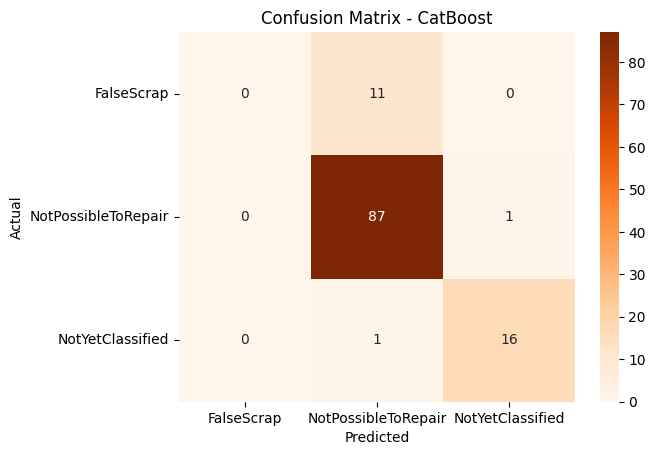


=== LightGBM ===
                     precision    recall  f1-score   support

         FalseScrap       0.38      0.45      0.42        11
NotPossibleToRepair       0.92      0.90      0.91        88
   NotYetClassified       0.94      0.94      0.94        17

           accuracy                           0.86       116
          macro avg       0.75      0.76      0.76       116
       weighted avg       0.87      0.86      0.87       116



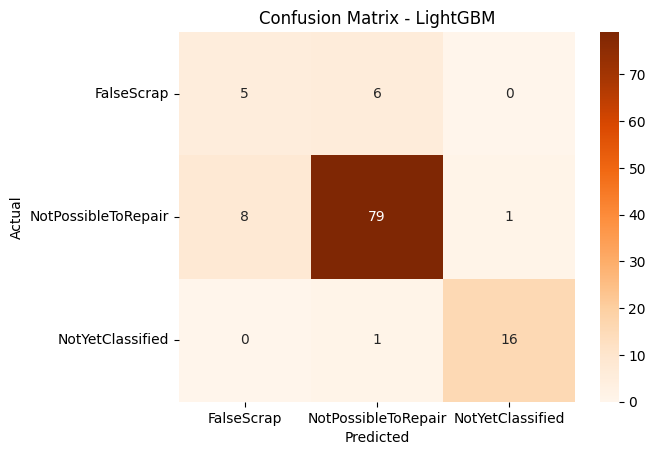


=== XGBoost ===
                     precision    recall  f1-score   support

         FalseScrap       0.36      0.36      0.36        11
NotPossibleToRepair       0.91      0.90      0.90        88
   NotYetClassified       0.89      0.94      0.91        17

           accuracy                           0.85       116
          macro avg       0.72      0.73      0.73       116
       weighted avg       0.85      0.85      0.85       116



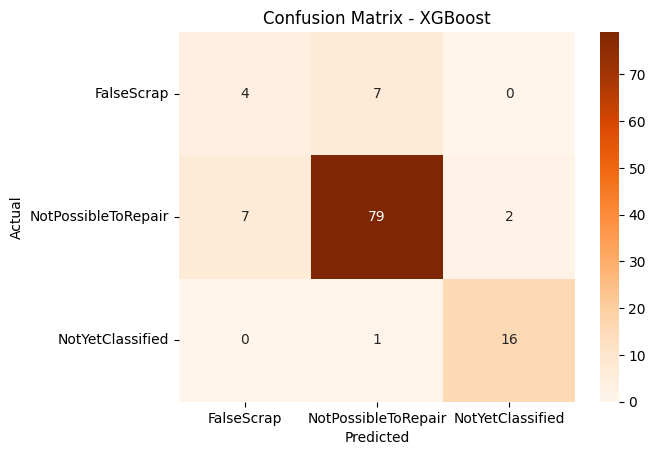


=== LSTM ===
                     precision    recall  f1-score   support

         FalseScrap       0.00      0.00      0.00        11
NotPossibleToRepair       0.88      0.98      0.92        88
   NotYetClassified       1.00      0.94      0.97        17

           accuracy                           0.88       116
          macro avg       0.63      0.64      0.63       116
       weighted avg       0.81      0.88      0.84       116



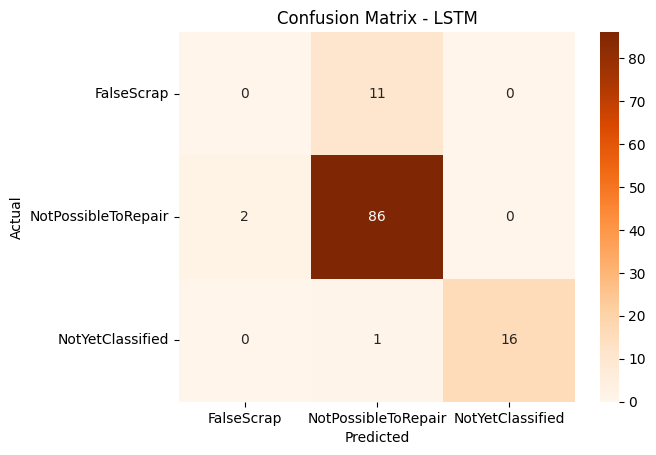

In [ ]:
evaluate_model(y_val, cat_model.predict(X_val), le, "CatBoost")
evaluate_model(y_val, lgb_model.predict(X_val), le, "LightGBM")
evaluate_model(y_val, xgb_model.predict(X_val), le, "XGBoost")
lstm_model.eval()
with torch.no_grad():
    tensor_val = torch.tensor(X_val_scaled, dtype=torch.float32)
    preds_lstm = lstm_model(tensor_val)
    lstm_preds = torch.argmax(preds_lstm, dim=1).numpy()
evaluate_model(y_val, lstm_preds, le, "LSTM")

## **Download LightGBM Model dalam format .pkl**

---



 LightGBM dipilih sebagai model terbaik untuk Task 3 karena kemampuannya dalam memberikan performa yang paling seimbang dan efektif. Hal ini dibuktikan dengan perolehan F1-score rata-rata (macro avg) tertinggi sebesar 0.76, yang menunjukkan kemampuannya secara konsisten dalam memprediksi semua kategori. Lebih penting lagi, LightGBM mencapai F1-score tertinggi (0.42) untuk kelas FalseScrap, menandakan keseimbangan terbaik antara menemukan komponen bagus yang salah deteksi oleh mesin (recall 0.45) dan tidak salah menandai (precision 0.38). Selain keunggulan performa ini, kecepatan training LightGBM yang secara umum lebih tinggi menjadikannya pilihan yang paling praktis dan efisien untuk diimplementasikan.

In [ ]:
best_model = lgb_model
model_filename = 'Task3_model_repair_label.pkl'

joblib.dump(best_model, model_filename)

['Task3_model_repair_label.pkl']